In [1]:
# Importing libraries
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy

import numpy as np

from gtda.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Plotting functions
from gtda.plotting import plot_diagram, plot_point_cloud, plot_heatmap

In [2]:
import tadasets
from matplotlib import pyplot as plt

We are going to explore how entropy performs at different sampling numbers. In the topic paper the authors show that it is possible to distinguish small (less than 30 points) point clouds through statistical tests on the entropy parameter.

We would like to perform the same computation with other parameters (mean, distance variance) and plot the results over the sampling size.

If possible we will have try and distinguish different sampling schemes on other topological shapes in 3D (sphere, torus, cube).

In [35]:
from scipy.stats import mannwhitneyu

In [36]:
def pentropy(sampling1, sampling2):
    """
    """
    VR = VietorisRipsPersistence(homology_dimensions=(0,1,2))
    diagrams = VR.fit_transform([sampling1, sampling2])
    PE = PersistenceEntropy()
    return PE.fit_transform(diagrams)
    
def pvalues(t1, t2):
    tests = [
        (t1.mean(axis=1), t2.mean(axis=1)),
        (t1.max(axis=1), t2.max(axis=1)),
        (t1.min(axis=1), t2.min(axis=1)),
        (np.square(t1).sum(axis=1), np.square(t2).sum(axis=1)),
    ]
    results = [mannwhitneyu(a,b) for (a,b) in tests]
    return np.asarray([r.pvalue for r in results])

In [37]:
def dataset(i, j, samples = 30, rows=10):
    v = np.zeros((rows, 4))

    surfaces = [
        lambda n: tadasets.torus(n, 2, 1),
        lambda n: tadasets.sphere(n, 1),
        lambda n: tadasets.swiss_roll(n),
    ]
    for row in range(rows):
        left = surfaces[i](samples)
        right = surfaces[j](samples)
        v[row] = pvalues(left, right)
    return v

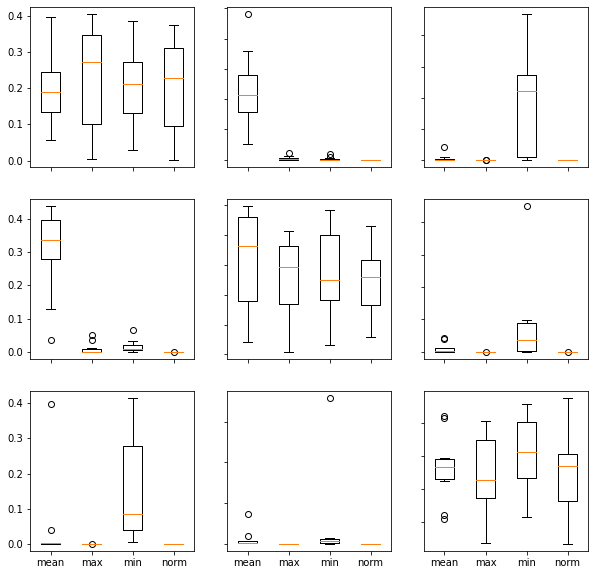

In [38]:
labels = ['mean', 'max', 'min', 'norm']

fig, axs = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        v = dataset(i,j)
        axs[i,j].boxplot(v, labels=labels)

for ax in axs.flat:
    ax.label_outer()

In [39]:
def entropy_dataset(i, j, samples=30, retries=10):
    """Draw `retries` time samples from two surfaces
    and compute the persistent entropy of the associated
    barcode.
    """
    surfaces = [
        lambda n: tadasets.torus(n, 2, 1),
        lambda n: tadasets.sphere(n, 1),
        lambda n: tadasets.swiss_roll(n),
    ]
    vp = np.zeros((retries, 2, 3))
    for row in range(retries):
        left = surfaces[i](samples)
        right = surfaces[j](samples)
        vp[row] = pentropy(left, right)
    return vp

In [40]:
def entropy_rank(rows=10, retries=10,sample_size=30):
    """Compute the p-value of when using entropy
    as a parameter of the samplings"""
    entropies_pvalues = np.zeros((3, 3, rows, 3))
    for i in range(3):
        for j in range(3):
            for row in range(rows):
                # for each row of our dataset
                # we need values of entropy to compare
                # in our test
                vp = entropy_dataset(i, j, samples=sample_size, retries=retries)
                left, right = vp[:,0], vp[:,1]
                for d in range(3):
                    # for each dimension of homology
                    # we make a test and record the value
                    entropies_pvalues[i,j,row,d] = mannwhitneyu(left[d], right[d]).pvalue
    return entropies_pvalues

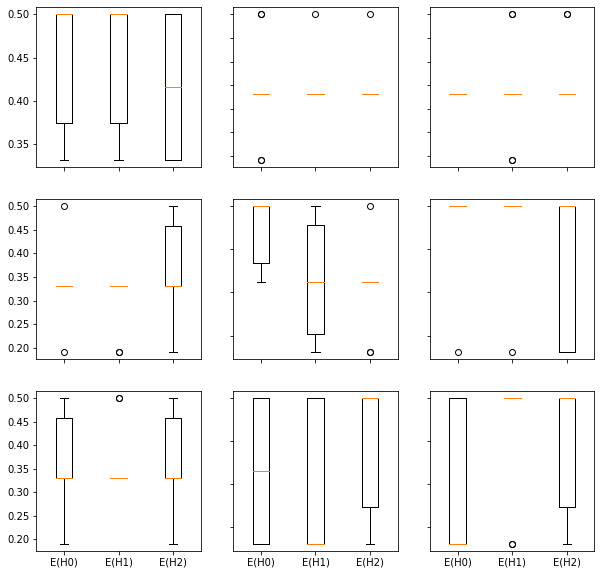

In [34]:
e_fig, e_axs = plt.subplots(3,3, figsize=(10,10))
entropy_labels = ['E(H0)', 'E(H1)', 'E(H2)']
entropy_pvalues = entropy_rank(sample_size=100)
for i in range(3):
    for j in range(3):
        e_axs[i,j].boxplot(entropy_pvalues[i,j], labels=entropy_labels)

for ax in e_axs.flat:
    ax.label_outer()